<div>
    <img src="img/Logo.png" align="right" width="200"</img>
</div>
<br/> 


# Diffusion Tensor Estimation

### Loading files

First, we load the data. There are 4 different files: 
1. the diffusion encoding gradient directions  "bvecs_64.txt"
2. a simulated signal of a single fiber "singleFiber.txt"
3. a simulated signal of 2 fibers crossing at an angle of 60 degrees . "60_deg_crossing.txt"
4.  a simulated signal of 2 fibers crossing at an angle of 60 degrees . "60_deg_crossing.txt"

In [5]:
# Import libraries
%matplotlib widget
import numpy as np
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation

# import Data

# gradDirections holds 1 Matrix with the diiffusion gradient directions
gradDirections = np.genfromtxt("data/bvecs_64.txt",delimiter=" ")

# Signal of a single fiber Voxel, 60 degree crossing and 90 degree crossing
# first Signal is B0 Value the 64 diffusion directions amplitudes
Ssf = np.genfromtxt("data/singleFiber.txt",delimiter=" ")
S60 = np.genfromtxt("data/60_deg_crossing.txt",delimiter=" ")
S90 = np.genfromtxt("data/90_deg_crossing.txt",delimiter=" ")

## Task
Print the shape of the vectors containing the diffusion encoding gradient directions and the single fiber signal. Why does the signal contain one value more?
Plot the diffusion encoding direction as a 3D scatter plot. (Plot a transparent sphere with radius 1)

(64, 3)
(65,)


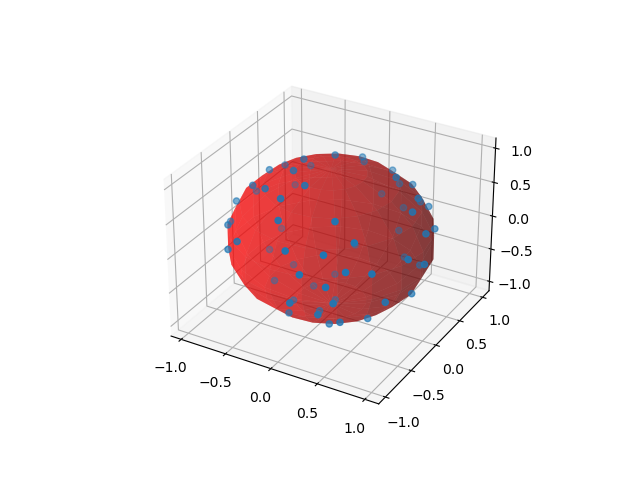

In [6]:
## Add your code here:

print(gradDirections.shape)
print(Ssf.shape)

xs = gradDirections[:,0]
ys = gradDirections[:,1]
zs = gradDirections[:,2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs,ys,zs)
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, alpha=.5, color="r")
animate = False
if (animate == True):
    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        ax.view_init(elev=10., azim=i)
        return fig,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=200, interval=20, blit=True)
    anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()



## Task: Create the matrix M
The Matrix M has a shape of (n,6) and contains the n diffusion encoding gradient directions in the following way:
$$
\begin{equation*}
M = \left(\begin{array}{rrrrrr}
x_1^2 &y_1^2& z_1^2& 2x_1y_1& 2x_1z_1 &2y_1z_1 \\
x_2^2 &y_2^2& z_2^2& 2x_2y_2& 2x_2z_2 &2y_2z_2 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_n^2 &y_n^2& z_n^2& 2x_ny_n& 2x_nz_n &2y_nz_n \\
\end{array} \right)
\end{equation*}
$$

Define a function that creates a Matrix of shape (n,6). As a parameter the function takes the gradient directions. 
The funtions returns the matrix.

In [3]:
# Add your code here:
# create Matrix M
def createM(directions):
    h = len(directions)
    M = np.zeros((h, 6))
    for k in range(h):
        x = directions[k,0]
        y = directions[k,1]
        z = directions[k,2]
        M[k,0] = x * x
        M[k,1] = y * y
        M[k,2] = z * z
        M[k,3] = 2 * x * y
        M[k,4] = 2 * x * z
        M[k,5] = 2 * y * z
    return M

## Task: Create the signal vector S
The vector S has the following shape:
$$
\begin{equation*}
\vec{S} = -\frac{1}{b} \left(\begin{array}{rrr} & ln(S0) &- &ln(S_1) \\ 
                                                & ln(S0) &- &ln(S_2) \\ 
                                                &\vdots  &\vdots &\vdots  \\ 
                                                &ln(S0)  &- &ln(S_n) \end{array} \right)
\end{equation*}
$$
Define a function that takes a signal and a B0-Value as parameter, creates the vector S, and returns the vector S.

In [4]:
# Add your code here
# create the vector S
def createS(signal, bValue):
    h = len(signal)
    S = np.zeros(h-1)
    S0 = signal[0]
    for k in range(h - 1):
        Sk = signal[k + 1]
        S[k] = ( np.log(Sk) - np.log(S0) ) / bValue 
    return S

## Task: create the Diffusion Tensor
The log-transformed signal vector S is the result of the matrix multiplication of M and D. 
$$
S = M \cdot D
$$
D is a vector containing the elements of the diffusion tensor:
$$
\begin{equation*}
\vec{D} = \left( \begin{array}{rrrrrr} 
D_{xx} & D_{yy} & D_{zz} & D_{xy} & D_{xz}& D_{yz}
\end{array}
\right)
\end{equation*}
$$
From the vector D the diffusion tensor DT has to be created:
$$
\begin{equation*}
DT = \left( \begin{array}{rrr}
D_{xx} & D_{xy} & D_{xz} \\ 
D_{xy} & D_{yy} & D_{yz} \\
D_{xz} & D_{yz} & D_{zz} \\ 
\end{array}\right)
\end{equation*}
$$
Define a function that takes the vector D as a parameter and creates and returns the diffusion vector DT.

In [30]:
#create the Diffusion Tensor from the Vector D
def createDT(D):
    DT = [[D[0], D[3], D[4]], 
          [D[3], D[1], D[5]],
          [D[4], D[5], D[2]]];
    return DT

## Task: calculate the FA value
The diffusion tensor can be thougt of an ellipsoid, a surface representing the distance that a molecule wil diffuse to with equal probability from the origin:
<div>
<img src="img/DT.png" width="300"/>
</div>

Here  $\lambda_1 \ge \lambda_2 \ge \lambda_3 $  are the sorted eigenvalues of the diffusion-tensor matrix. These measures indicate the degree of linear, planar, and spherical anisotropy, respectively. The associated eigenvectors $\vec{v_1}$, $\vec{v_2}$ and $\vec{v_3}$ form an orthonormal frame corresponding to the directionality of diffusion. The Fractional Anisotropy (FA can be calculated by:
$$
FA = \sqrt{ \frac{3}{2} 
\frac{ (\lambda_1  - \overline{\lambda} )^2 + ( \lambda_2 - \overline{\lambda})^2 + ( \lambda_3 - \overline{\lambda})^2}{\lambda_1^2 +\lambda_2^2 + \lambda_3^2} ) }$
$$
where
$\overline{\lambda} = \frac{1}{3} (\lambda_1 + \lambda_2 + \lambda_3)$$
Define a function that takes the diffusion tensor matrix DT as a parameter and calculates the Fa value. Use the eigendecomposition the get eigenvalues and eigenvectors:
```python
ew,ev = np.linalg.eig(DT)
```

In [31]:
# Add your code here
# calculate the FA Value from the Diffusion Tensor
def tensor2FA(DT):
    ew,ev = np.linalg.eig(DT)
    # Average of Lambda 
    l1 = abs(ew[0])
    l2 = abs(ew[1])
    l3 = abs(ew[2])
    la = (l1 + l2 + l3) /3
    FA = np.sqrt(3* (( (l1-la)**2 + (l2-la)**2 + (l3-la)**2 )) / (2 *(l1**2 + l2**2 + l3**2)))
    return FA

### Plotting a diffusion tensor
this function takes a 3x3 matrix as input and plots an ellipsoid. The eigenvectors are calculated be eigendecomposition.

In [32]:
def plotTensor(DT):

    # Eigendecomposition
    ew,ev = np.linalg.eig(DT);
    
    # data points
    phi = np.linspace(0,2*np.pi, 256).reshape(256, 1) # the angle of the projection in the xy-plane
    theta = np.linspace(0, np.pi, 256).reshape(-1, 256) # the angle from the polar axis, ie the polar angle

    # Spherical coordinates
    x = ew[0]*np.sin(theta)*np.cos(phi);
    y = ew[1]*np.sin(theta)*np.sin(phi);
    z = ew[2]*np.cos(theta);
    
    # 3DPlot
    fig = plt.figure(figsize=plt.figaspect(1));  # Square figure
    ax = fig.add_subplot(1,1,1, projection='3d');
    ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z))) # axis equal workaround
    ax.plot_surface(x, y, z, color='b');
    plt.show();
    return ax

## Test the plotting function

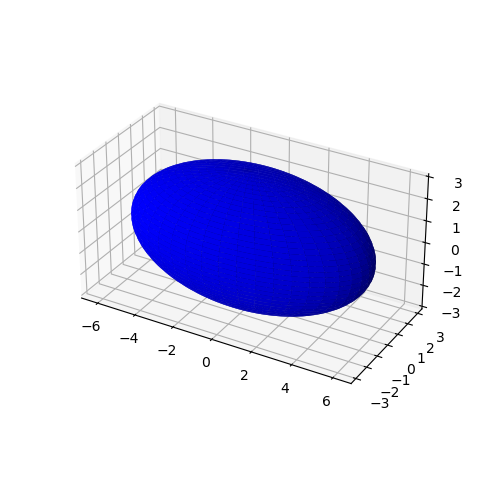

In [35]:
tensorTest = [[6, 0, 0], 
              [0, 3, 0],
              [0, 0, 3, ]];
ax = plotTensor(tensorTest)
ax.set_title(' Tensor ')
ax.view_init(elev=27., azim=20.)

## Task Calculate and plot the Diffusion Tensor
1. define a B0-Value of 1000, 
2. create the matrix M by calling your defined function
3. calculate the Pseudoinverse of M: 
``` python 
 Mi = np.linalg.pinv(M) 
```
4. create the vector S by calling your defined function
5. calculate D
6. create DT by calling your function
7. plot the ellipsoid
8. calculate FA by calling your function, set FA value into the title of the plot
```python
    FA = 0.8
    ax.set_title('Single Fiber, FA = {:.2f}'.format(FA))
```
9. repeat step 4 to 8 for the 60 degree and 90 degree crossing fibers signals


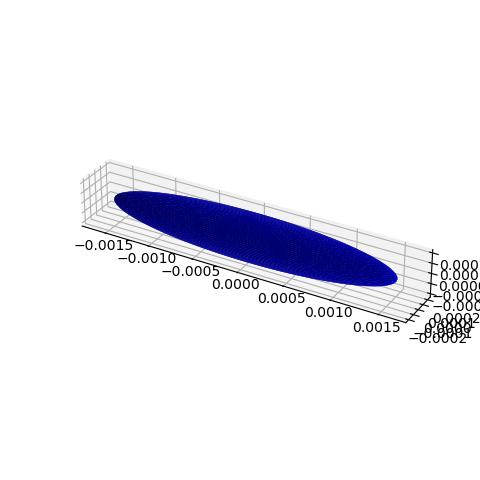

[[-0.0009340829692855945, -0.0002890806887882587, -1.075260432283214e-06], [-0.0002890806887882587, -0.0005921414741925554, -7.163043225464629e-07], [-1.075260432283214e-06, -7.163043225464629e-07, -0.00024554421937776443]]


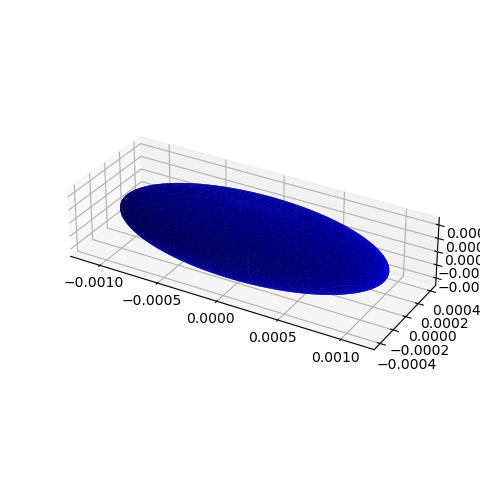

[[-0.0007249331312296509, 3.1091610753218905e-06, 5.752645023117636e-08], [3.1091610753218905e-06, -0.0002586520006486116, -5.084875014075378e-07], [5.752645023117636e-08, -5.084875014075378e-07, -0.0007046103334700282]]


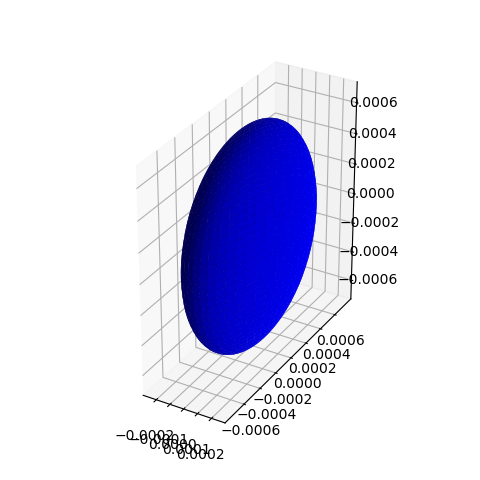

Text(0.5, 0.92, '90 deg Crossing, FA = 0.44')

In [37]:
# Add your code here:

# Calculation of Diffusiontensor
# step 1: B0 Value
bValue = 2000;
# step 2: matrix M
M = createM(gradDirections);
# step3: Pseudoinverse of M
Mi = np.linalg.pinv(M);

# Single Fiber
# step 4: create vector S
S = createS(Ssf, bValue);
# step 5: matrix multiplication
D = np.matmul(Mi,S);
# step 6: calculate 
DT = createDT(D);
#strep 7: Plot
ax = plotTensor(DT);
#step 8: calculate FA and st to title
FA = tensor2FA(DT);
ax.set_title('Single Fiber, FA = {:.2f}'.format(FA))

# 60 deg crossing
S = createS(S60, bValue)
D = np.matmul(Mi,S);
DT = createDT(D);
ax = print(DT);
FA = tensor2FA(DT)
ax = plotTensor(DT)
ax.set_title('60 deg Crossing, FA = {:.2f}'.format(FA))

# 90 deg crossing
S = createS(S90, bValue)
D = np.matmul(Mi,S);
DT = createDT(D);
ax = print(DT);
FA = tensor2FA(DT);
ax = plotTensor(DT);
ax.set_title('90 deg Crossing, FA = {:.2f}'.format(FA))

bash: line 1: zip: command not found


CalledProcessError: Command 'b'zip DT DiffusionTensor\n'' returned non-zero exit status 127.